### Strawberry Leaf Disease Classification using Transfer Learning by Fine-Tuning VGG16 Pre-trained Model.

### Introduction

In this notebook, we'll fine-tune a pre-trained MobileNetv2 model and use it to predict strawberry leaf disease. MobileNetv2 is one of the State-Of-The-Art pre-trained CNN models that was trained on IMAGENET 1000 classes image dataset.

Let's dive in.

### Import necessary libraries.

In [ ]:
import os
import cv2
import PIL
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json

This dataset was taken from this Kaggle link. https://www.kaggle.com/datasets/lavaman151/plantifydr-dataset

Here, we want to view a sample of our images. We'll use tf.keras image preprocessing library to load the image.

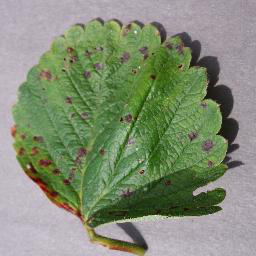

In [16]:
img1 =image.load_img('./Strawberry/train/Strawberry Leaf scorch/StrawberryLeafScorch(6).JPG')
img1

In [17]:
cv2.imread('./Strawberry/train/Strawberry Leaf scorch/StrawberryLeafScorch(6).JPG').shape

(256, 256, 3)

### Building the model.
First, we'll download the MobileNet model from tensorflow keras applications that we imported earlier and store it in a variable.

We don't want to include the last layer because its trained to classify 1000 classes of images. Our data has only 2 classes.

In [18]:
mobile_model = tf.keras.applications.mobilenet.MobileNet()

In [19]:
mobile_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [20]:
x = mobile_model.layers.output
x = tf.keras.layers.Reshape(target_shape=(1024,))(x)
output = Dense(units=2, activation='softmax')(x)

In [21]:
model = Model(inputs=mobile_model.input, outputs=output)

### Freezing the MobileNet layers.

All the layers in MobileNetv2 come as trainable by default. This means that we have to train all the layers completely from scratch. This will be a lot of computation. Using transfer learning, we want to retain the trained weights of the model and only train a few layers along with our added model layers.

In this case, we will set all layers to non-trainable.

In [22]:
for layer in model.layers:
    layer.trainable = False

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

### Preprocess training image data.

Here, we'll load in our data using ImageDataGenerator Class in tensorflow. This allows us to rescale our images and split the data into train and validation data. It also loads our images in a specified batch size.

In [24]:
IMAGE_SIZE = [224, 224]
train_dir = './Strawberry/train/'


train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )
val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    )  


train_set = train_gen.flow_from_directory(
    train_dir,
    subset = 'training',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

val_set = val_gen.flow_from_directory(
    train_dir,
    subset = 'validation',
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
    )

Found 4918 images belonging to 2 classes.
Found 1228 images belonging to 2 classes.


### Compile the model.

In [25]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
    )

We are now fitting the images into the model.

In [26]:
mobile_model = model.fit_generator(
     train_set,
     validation_data=val_set, 
     epochs=3, 
     steps_per_epoch = len(train_set),
     validation_steps = len(val_set),
     verbose=1)

C:\Users\Surface\AppData\Local\Temp\ipykernel_1844\3979519974.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mobile_model = model.fit_generator(


Epoch 1/3
308/308 [==============================] - 276s 855ms/step - loss: 0.2103 - accuracy: 0.9345 - val_loss: 0.0634 - val_accuracy: 0.9951
Epoch 2/3
308/308 [==============================] - 260s 835ms/step - loss: 0.0492 - accuracy: 0.9908 - val_loss: 0.0144 - val_accuracy: 0.9984
Epoch 3/3
308/308 [==============================] - 257s 825ms/step - loss: 0.0289 - accuracy: 0.9945 - val_loss: 0.0103 - val_accuracy: 0.9984


We want to save our model for later use so that we don't have to train it all over again to save time.

In [29]:
model.save('Mobilenet_strawberry.h5')

In [30]:
test_dir = './Strawberry/test/'
test_gen = ImageDataGenerator(rescale=1./255) 

test_set = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = IMAGE_SIZE,
    batch_size = 16
)

Found 12 images belonging to 2 classes.


In [28]:
mobile_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Evaluating our model.
Here, we'll plot the accuracy and loss for both training and validation data.

In [31]:
acc = mobile_model.history['accuracy']
val_acc = mobile_model.history['val_accuracy']

loss = mobile_model.history['loss']
val_loss = mobile_model.history['val_loss']

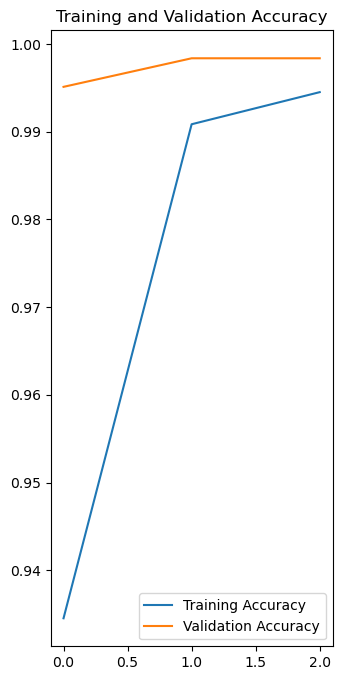

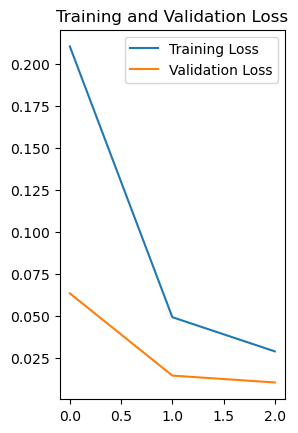

In [32]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy')
plt.plot(range(3), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss')
plt.plot(range(3), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making predictions with test images.

In [34]:
predictions = model.predict(test_set, verbose=0)

In [35]:
cm = confusion_matrix(y_true=test_set.classes, y_pred=predictions.argmax(axis=1))
cm

array([[7, 3],
       [2, 0]], dtype=int64)

ImageDataGenerator infers the class labels from the directories name. We want to check the class labels.

​

In [36]:
test_set.class_indices

{'Strawberry Healthy': 0, 'Strawberry Leaf scorch': 1}

### Evaluate our model.

We want to evaluate our model's performance with the test images.

In [38]:
scores = model.evaluate(test_set, batch_size=16, verbose=2)

1/1 - 1s - loss: 0.1588 - accuracy: 0.9167 - 1s/epoch - 1s/step
